In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

#!pip install multiprocess #multithreading designed for ipython. really speeds things up when using a 3900X
import multiprocess
from time import time

In [2]:
#Reference settings
#channel_num = 4 #number of channels
#fft_batch = 1280 #number of samples per FFT batch #band 128 #myo200 128 #myo2000 1280
#sampling_freq = 2000 #sampling rate used in calculating FFT #band ,myo200 200
#amplitude = 4096 #band 256 #myo 4096

#Three key gestures required for basic hand control
gestures = ('fist','rest','spread')

#for fairness, bin frequency range should remain constant between datasets.
#print('Frequency range of each bin: %fHz'%(sampling_freq/fft_batch))

In [11]:
def loadTrainingData(user='test',chnum=0,filenames=gestures):
    data = {}
    for g in gestures:
        df = pd.read_csv('%s_%s.csv'%(g,user),delimiter='\t',index_col=False,names=['CH%d'%i for i in range(chnum)])
        df['Label'] = g
        data[g] = df
    return data

def processBatch(data,batch,chnum,f_s,amp):
    import numpy as np
    from scipy import fft
    
    bins = int(batch/2)
    out = {}
    for c in range(chnum):
        wave = np.array(data['CH%d'%c],dtype=np.float64)
        for i,x in enumerate(np.abs(fft(wave))):
            out['B%dCH%d'%(i,c)] = x
        out['CH%dS'%c] = np.mean(np.abs(wave-amp/2))
    out['Label'] = data['Label'].iloc[0]
    return out

def splitBatch(data,fft_batch,channel_num,sampling_freq,amplitude):
    return [(df.iloc[n:n+fft_batch,:],fft_batch,channel_num,sampling_freq,amplitude) for df in data.values() for n in range(0,len(df),fft_batch)]

def pcaData(data,seeds=range(1000),ncomps=32):
    dfy = np.array(data.Label)
    dfv = data.drop(('Label'),axis=1).values
    pca = PCA(n_components=ncomps, whiten=True) #whiten in order for 'subtle' features to be respected
    dfx = pca.fit_transform(dfv)
    return [(i,dfx,dfy) for i in seeds]

def testSeed(seed,dfx,dfy):
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import BaggingClassifier
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score
    import gc
    print('%d started'%seed)
    
    xtrain,xtest,ytrain,ytest = train_test_split(dfx,dfy,test_size=0.25,random_state=seed,stratify=dfy)
    classifier = BaggingClassifier(base_estimator=SVC(random_state=seed,kernel='linear'),random_state=seed)
    classifier.fit(xtrain,ytrain)
    ypred = classifier.predict(xtest)
    score = accuracy_score(ytest, ypred)
    
    del dfx
    del dfy
    del ytrain
    del ytest
    del xtrain
    del xtest
    del classifier
    del ypred
    gc.collect()
    print('%d ended, score %f'%(seed,score))
    
    return (score,seed)

def printResult(data):
    data = sorted(data)
    vals = np.array([i[0] for i in data])
    mean = np.mean(vals)
    sigma = np.std(vals)
    print('Mean: %f'%mean)
    print('Min: %s'%str(data[0]))
    print('Max: %s'%str(data[-1]))
    print('SD: %f'%sigma)
    return (mean,sigma)

def processData(data,fft_batch,channel_num,sampling_freq,amplitude,n_pca_comps,samples_cut=800,timeout=60):
    pool = multiprocess.Pool(processes=48)
    result = None
    frange = float(sampling_freq)/fft_batch
    print('Frequency range of each bin: %fHz'%frange)
    try:
        batched = splitBatch(data,fft_batch,channel_num,sampling_freq,amplitude)
        featured = pd.DataFrame(pool.starmap(processBatch,batched)).dropna()
        print('Number of samples for each gesture: ')
        print(featured.Label.value_counts())
        print('Limiting samples to %d...'%samples_cut)
        print('Test set is 0.25 of total set!')

        queue = [pool.apply_async(testSeed,batch) for batch in pcaData(featured,ncomps=n_pca_comps)]
        start = time()
        result = []
        isAll = True
        while time() - start < timeout:
            isAll = True
            for res in queue:
                if res.ready(): result.append(res.get())
                else: isAll = False
        if not isAll: print('timed out!')
        
        mean,sigma = printResult(result)
    except KeyboardInterrupt:
        print('Halting...')
        return None
    finally:
        pool.terminate()
    return (mean,sigma,frange,len(featured),result)

def calculateTuning(data,chnum,sampling_freq,amplitude,tested_batch = (320,640,1280),tested_comp = (2,4,8,16,32)):
    tune_df = pd.DataFrame({},columns=(['samps','range','batch']+['C%d'% i for i in tested_comp]))
    for fft_batch in tested_batch:
        row = {'batch':fft_batch}
        for ncomps in tested_comp:
            res = processData(data,fft_batch,chnum,sampling_freq,amplitude,ncomps)
            if res == None: continue
            mean,sigma,frange,samples,result = res
            row['C%d'%ncomps] = mean
            row['range'] = frange
            row['samps'] = samples
        tune_df = tune_df.append(row,ignore_index=True)
    return tune_df

In [4]:
#For myoware, CH0 is inner wrist, CH1 is outer wrist, CH2 is inner forearm, CH3 is outer forearm
myoware_wet_2000_all = loadTrainingData(user='john_myoware_wet_2000_all',chnum=4)
myoware_wet_200_wrist = loadTrainingData(user='john_myoware_wet_200_wrist',chnum=1)
myoware_wet_2000_wrist = {k:v.loc[:,('CH0','Label')] for k,v in myoware_wet_2000_all.items()}

myoware_dry_2000_all = loadTrainingData(user='john_myoware_dry_2000_all',chnum=4)
myoware_dry_2000_wrist = {k:v.loc[:,('CH0','Label')] for k,v in myoware_dry_2000_all.items()}

myoband_200 = {k:v[v.CH0 != 'CH0'] for k,v in loadTrainingData(user='john_myoband',chnum=16).items()} #glitch in saving data
#NaNs due to glitches arent filled in nor removed as it is detrimental

In [12]:
#data, size of batch for FFT, number of channels, sampling frequency of data, amplitude of data, number of components for PCA
result = processData(myoware_wet_2000_all,1280,1,2000,4096,8)

Frequency range of each bin: 1.562500Hz
Number of samples for each gesture: 
fist      256
spread    256
rest      256
Name: Label, dtype: int64
Limiting samples to 800...
Test set is 0.25 of total set!
Mean: 0.972624
Min: (0.9375, 939)
Max: (1.0, 842)
SD: 0.010456


In [5]:
#data, number of channels, sampling frequency of data, amplitude, FFT batch sizes to test, PCA component numbers to test
calculateTuning(myoware_dry_2000_wrist,1,2000,4096,tested_batch=(320,640,1280),tested_comp=(4,8,16,32))

Frequency range of each bin: 6.250000Hz
Number of samples for each gesture: 
rest      1024
spread    1024
fist      1024
Name: Label, dtype: int64
Limiting samples to 800...
Test set is 0.25 of total set!
Mean: 0.360706
Min: (0.3151041666666667, 890)
Max: (0.41015625, 863)
SD: 0.015141
Frequency range of each bin: 6.250000Hz
Number of samples for each gesture: 
rest      1024
spread    1024
fist      1024
Name: Label, dtype: int64
Limiting samples to 800...
Test set is 0.25 of total set!
Mean: 0.357696
Min: (0.2981770833333333, 729)
Max: (0.4049479166666667, 342)
SD: 0.015364
Frequency range of each bin: 6.250000Hz
Number of samples for each gesture: 
rest      1024
spread    1024
fist      1024
Name: Label, dtype: int64
Limiting samples to 800...
Test set is 0.25 of total set!
timed out!
Mean: 0.354472
Min: (0.3059895833333333, 125)
Max: (0.4036458333333333, 409)
SD: 0.015846
Frequency range of each bin: 6.250000Hz
Number of samples for each gesture: 
rest      1024
spread    1024
fi

,samps,range,batch,C4,C8,C16,C32
0,3072.0,6.2500,320.0,0.360706,0.357696,0.354472,0.352613
1,1536.0,3.1250,640.0,0.365243,0.358606,0.351800,0.356402
2,768.0,1.5625,1280.0,0.345628,0.353520,0.350685,0.376241


In [13]:
#modified processData to return data from an earlier step
ch0_pca = pd.Series(result[0][1][0])
dfp = ch0_pca
ax = dfp.plot(kind='bar',figsize=(20,10),fontsize=14)
ax.set_xticklabels(['PC%d'%i for i in range(16)],rotation = 0)
ax.set_title('EMG Signal fingerprint from PCA', fontsize=22)
ax.set_yticks([])
ax.set_ylabel('Arbitrary Value', fontsize=18)
ax.set_xlabel('Principal Components',fontsize=18)

IndexError: invalid index to scalar variable.

In [14]:
#modified processData to return data from an earlier step
ch0_subset = result.filter(regex='CH0').drop(labels='CH0S',axis=1).iloc[27]
dfp = ch0_subset.rename(lambda x: (int(parse('B{}CH0',x)[0])+1)*3.125)
ax = dfp.plot(kind='line',ylim=(0,670),xlim=(1000,2000),figsize=(20,5),fontsize=14)
ax.set_xticklabels(['0','200','400','600','800','1000'])
ax.set_ylabel('Amplitude', fontsize=18)
ax.set_xlabel('Signal Frequency/Hz', fontsize=18)
ax.set_title('EMG Signal fingerprint from DFT', fontsize=22)
ax.set_yticks([])

AttributeError: 'tuple' object has no attribute 'filter'

[]

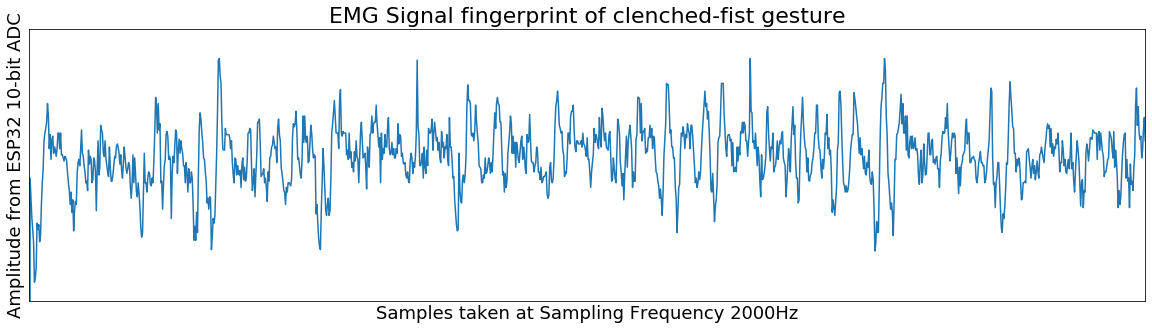

In [15]:
dfp = myoware_wet_2000_all['fist'].loc[:1280,'CH0']
ax = dfp.plot(kind='line',ylim=(1700,1875),figsize=(20,5),fontsize=14)
ax.set_ylabel('Amplitude from ESP32 10-bit ADC', fontsize=18)
ax.set_xlabel('Samples taken at Sampling Frequency 2000Hz', fontsize=18)
ax.set_title('EMG Signal fingerprint of clenched-fist gesture', fontsize=22)
ax.set_xticks([])
ax.set_yticks([])

In [283]:
#modified processData to return data from an earlier step
X = result[0][1][:,(3,4)]  # for illustration purposes, take only the first two PCs.
y = [gestures.index(y) for y in result[0][2]]
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
model = BaggingClassifier(base_estimator=SVC(kernel='linear'))
clf = model.fit(X, y)
#(0,3),(2,3), (3,4)

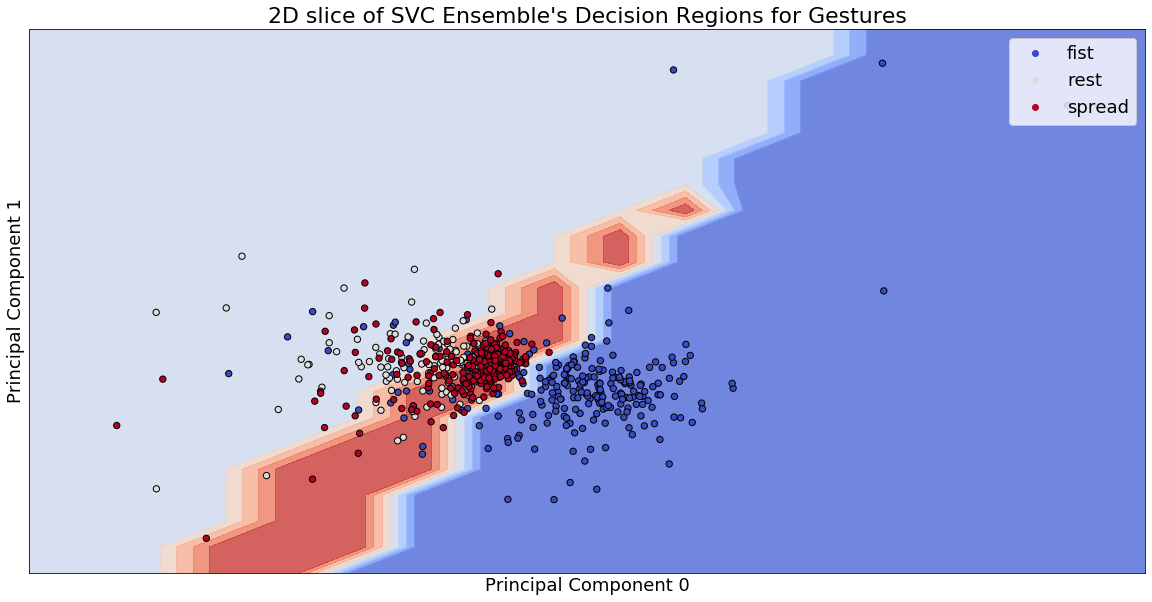

In [288]:
def make_meshgrid(x, y, h=0.75): # .02
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fig, ax = plt.subplots(figsize=(20,10))
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
scatter = ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=40, edgecolors='k')
ax.set_ylabel('Principal Component 1',fontsize=18)
ax.set_xlabel('Principal Component 0',fontsize=18)
ax.set_xticks(())
ax.set_yticks(())
ax.set_title("2D slice of SVC Ensemble's Decision Regions for Gestures",fontsize=22)
handles, labels = scatter.legend_elements()
ax.legend(handles, gestures, loc="upper right", fontsize=18)
plt.show()

In [230]:
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.hist(data,normed=True)
# Add labels
plt.title('Distribution of accuracy for Myoware wet @ 2000Hz')
mu = 0.949962
sigma = 0.012340
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
plt.plot(x,stats.norm.pdf(x, mu, sigma))
plt.xlabel('Accuracy')
plt.yticks([])
plt.show()

NameError: name 'data' is not defined

In [35]:
#gets sample and reshapes it into form used for SVM
def classifySample(socket=serial,chnum=channel_num,batch=fft_batch,f_s=sampling_freq,classes=gestures,pca=pca,clf=classifier):
    df = pd.DataFrame({},columns=('CH%d'%x for x in range(channel_num)))
    while len(df) < batch:
        inp = socket.read_until()
        try:
            out = inp.decode('utf8')
            if out[0].isdigit():
                rdata = out.split('\t')[:channel_num]
                df.loc[len(df),:] = rdata
                if len(df) % int(samples/8) == 0: print("%d samples"%iters)
            else:
                print("INFO: %s"%out)
        except:
            pass
    #print(df)
    pt = pd.Series(processBatch(df,batch,chnum,f_s))
    pt2 = pca.transform(pt)
    #TODO: flatten and reduce using PCA
    ans = clf.predict((pt2))[0]
    print(classes[ans])
    pt['Label'] = classes[ans]
    return pt

In [89]:
with serial.Serial('COM10',2000000) as s:
    print(classifySample(s))

rest
               0
B0CH0       7383
B0CH1       9434
B0CH10      6743
B0CH11      6993
B0CH12      7844
B0CH13      8137
B0CH14      9638
B0CH15      7383
B0CH2       9048
B0CH3       8154
B0CH4       8669
B0CH5       9436
B0CH6       7661
B0CH7       8403
B0CH8       8099
B0CH9       7118
B10CH0    1226.6
B10CH1   1220.34
B10CH10  463.074
B10CH11  459.625
B10CH12  324.213
B10CH13  246.516
B10CH14  1575.79
B10CH15  157.742
B10CH2   1054.82
B10CH3   696.852
B10CH4   486.377
B10CH5    1001.9
B10CH6   867.076
B10CH7   1189.32
...          ...
B8CH11    499.84
B8CH12   1062.33
B8CH13   1277.78
B8CH14   1810.96
B8CH15   651.582
B8CH2    1077.82
B8CH3    1303.99
B8CH4     739.56
B8CH5    1094.33
B8CH6    1500.21
B8CH7    877.258
B8CH8    322.317
B8CH9    396.313
B9CH0    929.136
B9CH1    1137.83
B9CH10   732.992
B9CH11   1312.12
B9CH12   714.377
B9CH13   945.882
B9CH14   313.373
B9CH15   1238.84
B9CH2     968.53
B9CH3    813.258
B9CH4    1443.67
B9CH5    1703.95
B9CH6    1424.31
B9CH7    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
